<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Import Required Libraries
    </p>
</div>

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
   Define File Path
    </p>
</div>

In [94]:
filepath = '../data/newMed_events.csv'

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
   Load and Clean Data
    </p>
</div>

In [95]:
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['eksd'])
    df['eksd'] = pd.to_datetime(df['eksd'], format='%Y-%m-%d')
    df.dropna(subset=['eksd', 'pnr'], inplace=True)
    
    return df

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Loads the dataset and performs basic cleaning.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Reads the CSV file into a DataFrame using <code>pandas</code>.</li>
            <li>Converts the <code>eksd</code> column to a datetime format.</li>
            <li>Drops rows with missing values in critical columns (<code>eksd</code>, <code>pnr</code>).</li>
        </ul>
        <li><strong>Returns:</strong> A cleaned DataFrame with no missing data in key columns.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Preprocess Data for Specific ATC Code
    </p>
</div>

In [96]:
def preprocess_data(tidy, atc_code):
    subset = tidy[tidy['ATC'] == atc_code].sort_values(by=['pnr', 'eksd'])
    subset['prev_eksd'] = subset.groupby('pnr')['eksd'].shift(1)
    subset.dropna(subset=['prev_eksd'], inplace=True)
    
    return subset[['pnr', 'eksd', 'prev_eksd']]

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Filters the dataset for a specific ATC code and prepares it for further analysis.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Filters the DataFrame for records matching the specified <code>atc_code</code>.</li>
            <li>Sorts the data by patient number (<code>pnr</code>) and event date (<code>eksd</code>).</li>
            <li>Creates a new column <code>prev_eksd</code> to store the previous event date for each patient.</li>
        </ul>
        <li><strong>Returns:</strong> A DataFrame containing only relevant records and event intervals.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Compute Event Intervals
    </p>
</div>

In [97]:
def compute_event_intervals(subset):
    subset['event.interval'] = (subset['eksd'] - subset['prev_eksd']).dt.days
    return subset

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Computes the event intervals (time difference between consecutive events) for each patient.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Calculates the difference in days between the current event (<code>eksd</code>) and the previous event (<code>prev_eksd</code>) for each patient.</li>
        </ul>
        <li><strong>Returns:</strong> A DataFrame with the newly computed event intervals for each patient.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Compute ECDF (Empirical Cumulative Distribution Function)
    </p>
</div>

In [98]:
def compute_ecdf(data):
    sorted_intervals = np.sort(data['event.interval'].values)
    yvals = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    
    return pd.DataFrame({'x': sorted_intervals, 'y': yvals})

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Computes the ECDF for the event intervals to understand their distribution.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Sorts the event intervals and computes their cumulative probability.</li>
            <li>Returns the ECDF values in a new DataFrame with <code>x</code> as event intervals and <code>y</code> as cumulative probability.</li>
        </ul>
        <li><strong>Returns:</strong> A DataFrame with the computed ECDF values.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    KMeans Clustering
    </p>
</div>

In [99]:
def kmeans_clustering(dfper, n_clusters=3):
    X = dfper[['x']].values
    X_scaled = StandardScaler().fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    dfper['cluster'] = labels
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {score:.4f}")
    
    return dfper

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Applies KMeans clustering to the ECDF data to identify patterns in event intervals.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Scales the event interval data using <code>StandardScaler</code> before applying clustering.</li>
            <li>Performs KMeans clustering with a specified number of clusters (<code>n_clusters</code>).</li>
            <li>Assigns each data point to a cluster and returns the labeled data.</li>
        </ul>
        <li><strong>Returns:</strong> The DataFrame with added cluster labels.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Assign Clusters Based on Event Intervals
    </p>
</div>

In [100]:
def assign_clusters(event_data, dfper):
    dfper = dfper[dfper['x'] > 0]
    if dfper.empty:
        print("Warning: dfper has no valid values after removing zeros.")
        return event_data

    dfper = dfper.copy()
    dfper['log_x'] = np.log(dfper['x'])
    summary = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    summary[['Minimum', 'Maximum', 'Median']] = np.exp(summary[['min', 'max', 'median']])

    if 'cluster' not in event_data.columns:
        event_data['cluster'] = 0

    event_data = event_data.merge(summary[['cluster', 'Minimum', 'Maximum']], how='left', on='cluster')
    event_data[['Minimum', 'Maximum']] = event_data[['Minimum', 'Maximum']].fillna(0)

    event_data['cluster'] = np.where((event_data['event.interval'] >= event_data['Minimum']) &
                                     (event_data['event.interval'] <= event_data['Maximum']),
                                     event_data['cluster'], 0)
    return event_data

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Assigns each event to a cluster based on its event interval.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Filters the data to remove zero event intervals.</li>
            <li>Computes the summary statistics (min, max, median) for each cluster.</li>
            <li>Merges the summary with the original event data and assigns clusters based on event intervals.</li>
        </ul>
        <li><strong>Returns:</strong> The original event data with the assigned cluster labels.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Plot ECDF for 80% and 100% Event Intervals
    </p>
</div>

In [101]:
def plot_ecdf(filtered_percentile, empirical_cdf):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(filtered_percentile["x"], filtered_percentile["y"], label="80% ECDF", color='#F2A7D2')
    axes[0].set_title("80% ECDF", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Event Interval", fontsize=14)
    axes[0].set_ylabel("Cumulative Probability", fontsize=14)

    axes[1].plot(empirical_cdf.x, empirical_cdf.y, label="100% ECDF", color='#9B4F96')
    axes[1].set_title("100% ECDF", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Event Interval", fontsize=14)
    axes[1].set_ylabel("Cumulative Probability", fontsize=14)

    plt.tight_layout()
    plt.show()

<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Visualizes the ECDF for the filtered (80%) and full (100%) event intervals.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Creates subplots to show the ECDF for the filtered and full event intervals.</li>
            <li>Plots the cumulative probability for both datasets.</li>
        </ul>
        <li><strong>Returns:</strong> Two ECDF plots displayed side by side.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Plot KDE (Kernel Density Estimate)
    </p>
</div>

In [102]:
def plot_kde(filtered_percentile):
    eps = 1e-6
    
    filtered_percentile = filtered_percentile[filtered_percentile["x"] > 0].copy()
    
    log_transformed_x = np.log(filtered_percentile["x"] + eps)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(log_transformed_x, label="Log(event interval)", fill=True, color='#C86EAC', ax=ax)
    
    ax.set_title("Log(Event Interval) KDE", fontsize=16, fontweight='bold')
    ax.set_xlabel("Log(Event Interval)", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    plt.tight_layout()
    plt.show()

    return log_transformed_x


<div style="background-color: #f0f8ff; padding: 15px; border-radius: 8px; border-left: 5px solid #4CAF50;">
    <p style="font-size: 20px; color: #4CAF50; font-weight: bold;">✅ What this does:</p>
    <ul style="font-size: 16px; color: #333; line-height: 1.6;">
        <li>Plots the Kernel Density Estimate (KDE) for the log-transformed event intervals.</li>
        <li><strong>Steps:</strong></li>
        <ul>
            <li>Log-transforms the event intervals to better analyze their distribution.</li>
            <li>Plots the KDE for the log-transformed event intervals to visualize density.</li>
        </ul>
        <li><strong>Returns:</strong> A KDE plot for log-transformed event intervals.</li>
    </ul>
</div>


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Main Function to Process and Visualize KMeans Clustering
    </p>
</div>

In [122]:
def see_kmeans(atc_code, tidy, n_clusters=3):
    event_data = preprocess_data(tidy, atc_code)
    event_data = compute_event_intervals(event_data)
    dfper = compute_ecdf(event_data)
    dfper_80 = dfper[dfper['y'] <= 0.8]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(dfper_80["x"], dfper_80["y"], label="80% ECDF", color='#F2A7D2')
    axes[0].set_title("80% ECDF", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Event Interval", fontsize=14)
    axes[0].set_ylabel("Cumulative Probability", fontsize=14)
    
    axes[1].plot(dfper.x, dfper.y, label="100% ECDF", color='#9B4F96')
    axes[1].set_title("100% ECDF", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Event Interval", fontsize=14)
    axes[1].set_ylabel("Cumulative Probability", fontsize=14)

    plt.tight_layout()
    plt.show()

    dfper = kmeans_clustering(dfper, n_clusters=n_clusters)
    log_transformed_x = plot_kde(dfper_80)

    fig, ax = plt.subplots(figsize=(12.9, 6))
    scatter = ax.scatter(dfper['x'], dfper['y'], c=dfper['cluster'], cmap='plasma')
    ax.set_title(f"KMeans Clustering (n_clusters={n_clusters})", fontsize=16, fontweight='bold')
    ax.set_xlabel("Event Interval", fontsize=14)
    ax.set_ylabel("Cumulative Probability", fontsize=14)

    plt.colorbar(scatter, ax=ax, label="Cluster")
    plt.tight_layout()
    plt.show()

    return assign_clusters(event_data, dfper)


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Visualize Assumptions on Event Duration by Patient Number
    </p>
</div>

In [114]:
def see_assumption(data):
    data.sort_values(by=['pnr', 'eksd'], inplace=True)
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data['p_number'] = data.groupby('pnr').cumcount() + 1
    filtered_data = data[data['p_number'] >= 2].copy()
    filtered_data['Duration'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days

    plt.close()

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set(style="whitegrid")
    sns.boxplot(x='p_number', y='Duration', data=filtered_data, ax=ax, hue='p_number', palette="muted", legend=False)

    ax.set_title('Event Duration by Patient Number', fontsize=16, fontweight='bold')
    ax.set_xlabel('Patient Number', fontsize=14)
    ax.set_ylabel('Duration (Days)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.show()

    return fig


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Load and Clean the Data
    </p>
</div>

In [105]:
tidy = load_and_clean_data(filepath)

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    KMeans Clustering of medA
    </p>
</div>

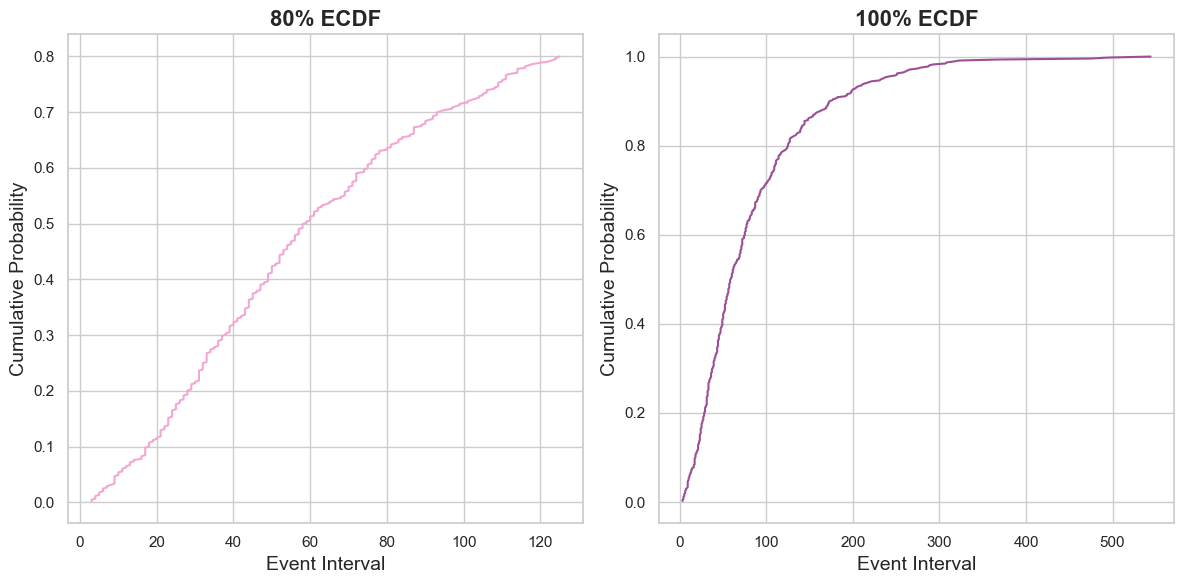

Silhouette Score: 0.6076


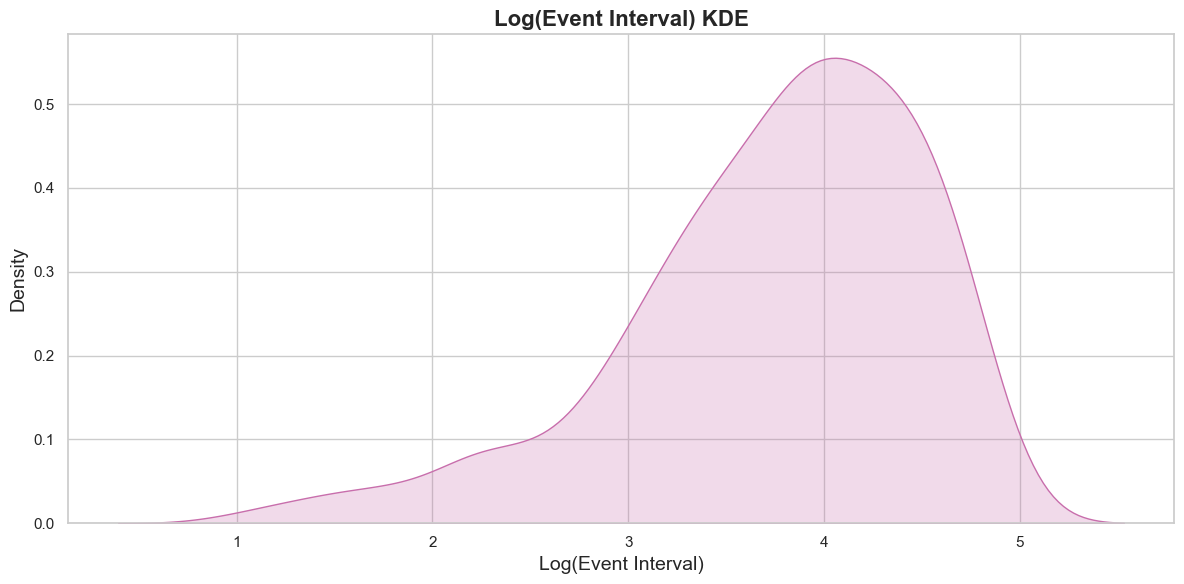

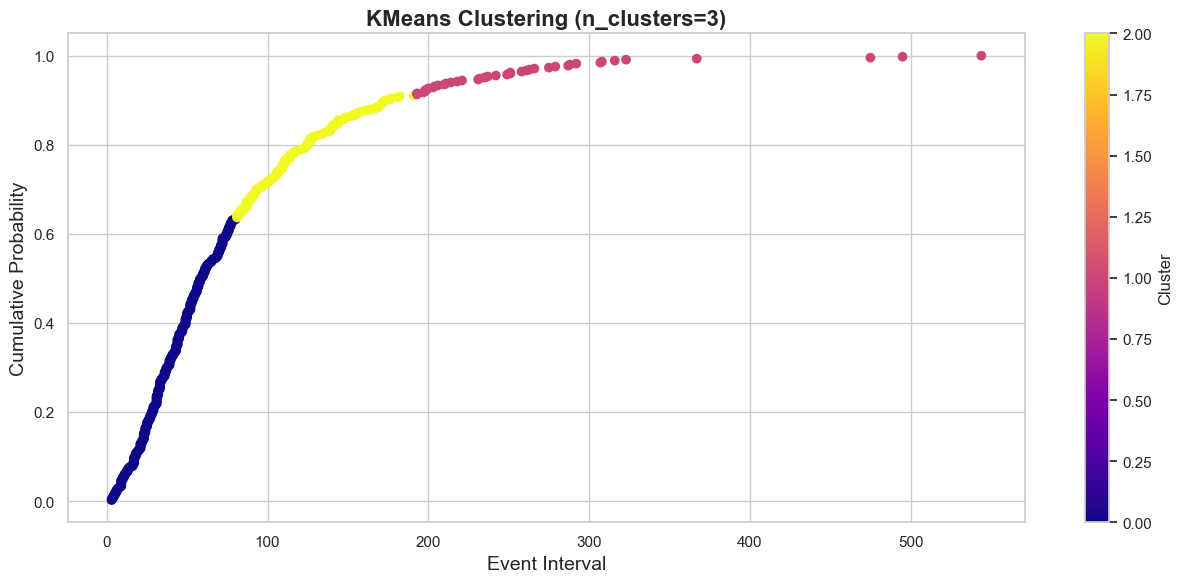

In [123]:
medA_clustered = see_kmeans('medA', tidy)

In [107]:
medA_clustered.head()

,pnr,eksd,prev_eksd,event.interval,cluster,Minimum,Maximum
0,2,2036-03-10,2036-01-20,50,0,3.0,80.0
1,2,2036-08-01,2036-03-10,144,0,3.0,80.0
2,4,2032-11-27,2032-05-01,210,0,3.0,80.0
3,4,2033-08-20,2032-11-27,266,0,3.0,80.0
4,4,2033-08-30,2033-08-20,10,0,3.0,80.0


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    KMeans Clustering of medB
    </p>
</div>

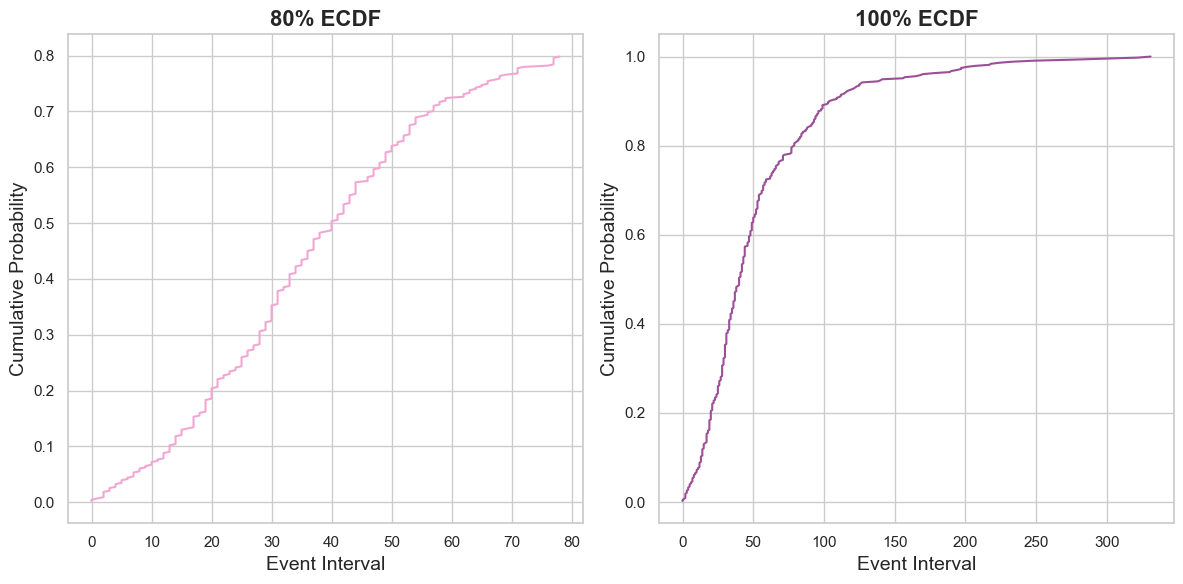

Silhouette Score: 0.6473


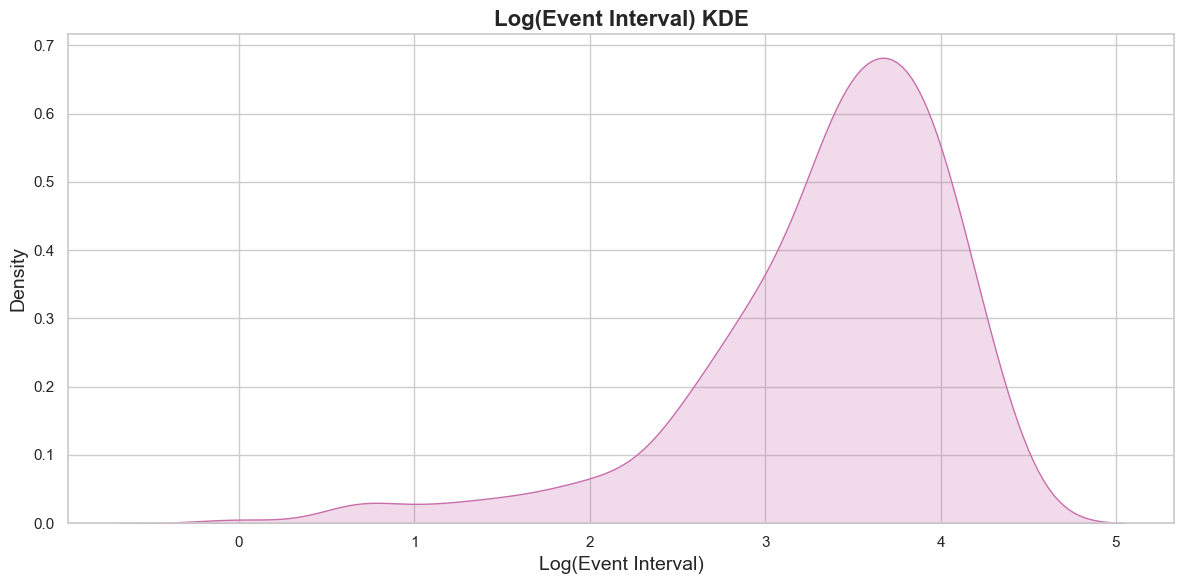

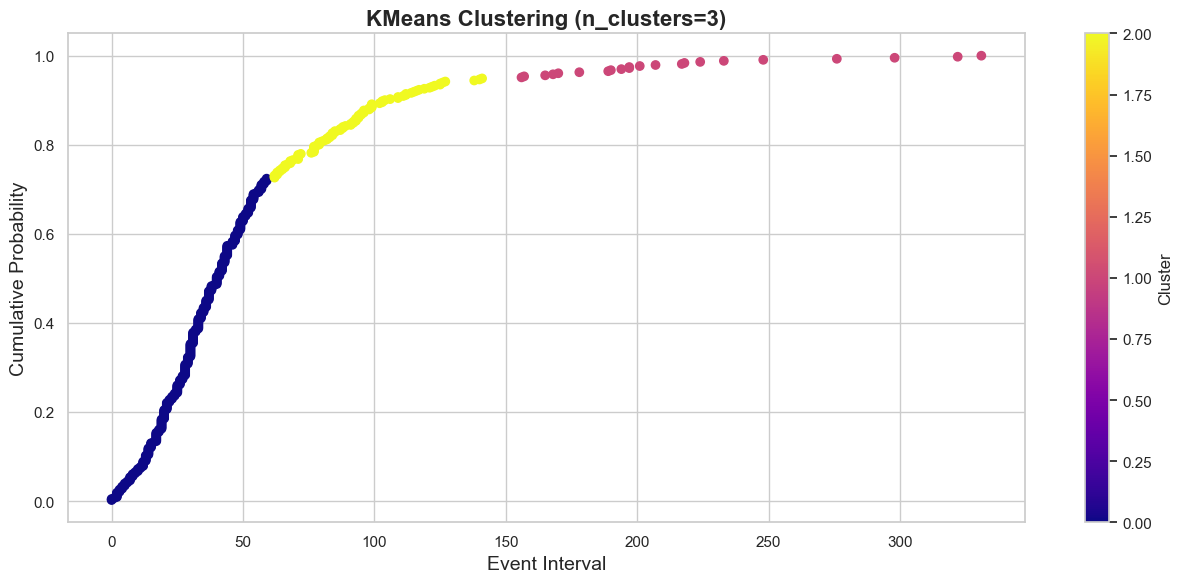

In [124]:
medB_clustered = see_kmeans('medB', tidy)

In [109]:
medB_clustered.head()

,pnr,eksd,prev_eksd,event.interval,cluster,Minimum,Maximum
0,1,2033-08-03,2033-07-04,30,0,1.0,59.0
1,1,2033-08-17,2033-08-03,14,0,1.0,59.0
2,1,2033-10-13,2033-08-17,57,0,1.0,59.0
3,1,2033-10-16,2033-10-13,3,0,1.0,59.0
4,1,2033-11-23,2033-10-16,38,0,1.0,59.0


<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Assumption for KMeans Clustering of medA
    </p>
</div>

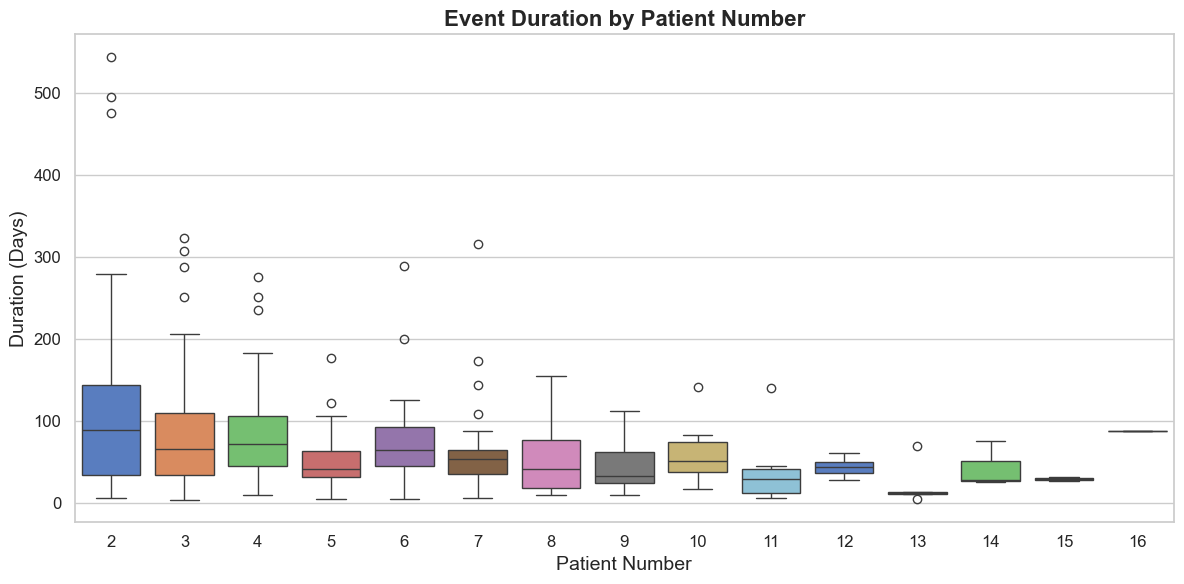

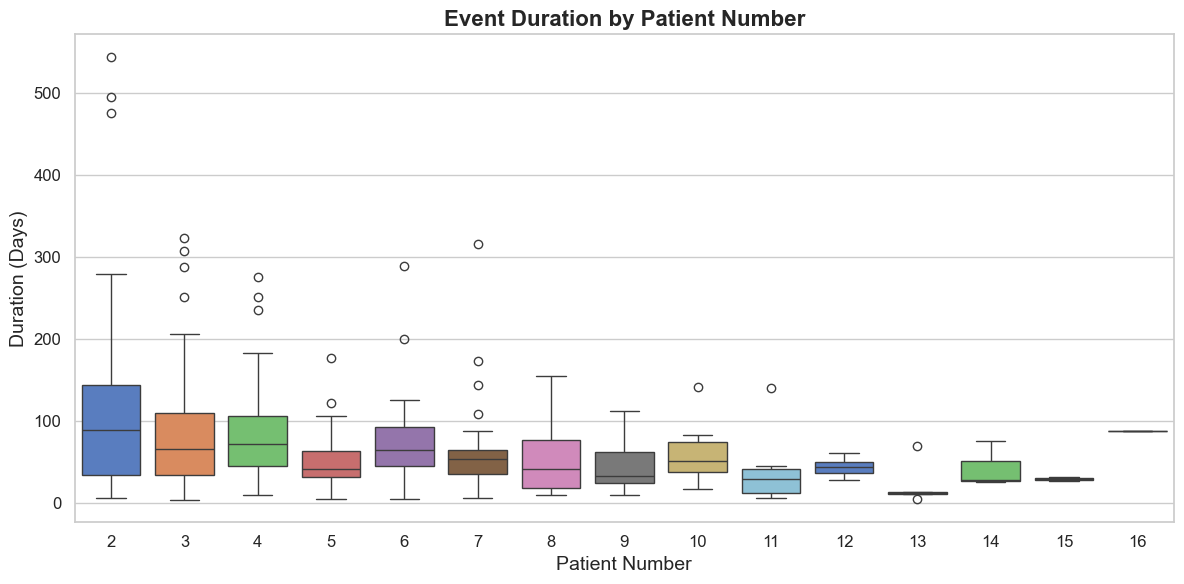

In [110]:
see_assumption(medA_clustered)

<div style="background-color: #fff0f5; padding: 15px; border-radius: 8px; border-left: 5px solid #ff69b4;">
    <p style="color:#ff69b4; font-family: 'Comic Sans MS', cursive; font-size: 22px; font-weight: bold; margin: 0;">
    Assumption for KMeans Clustering of medB
    </p>
</div>

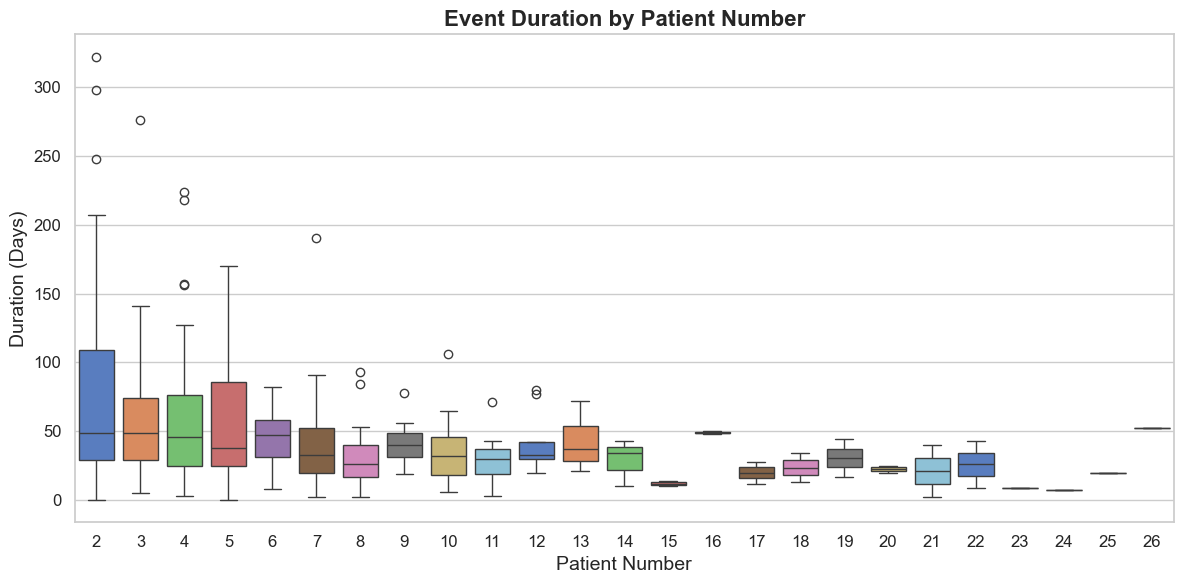

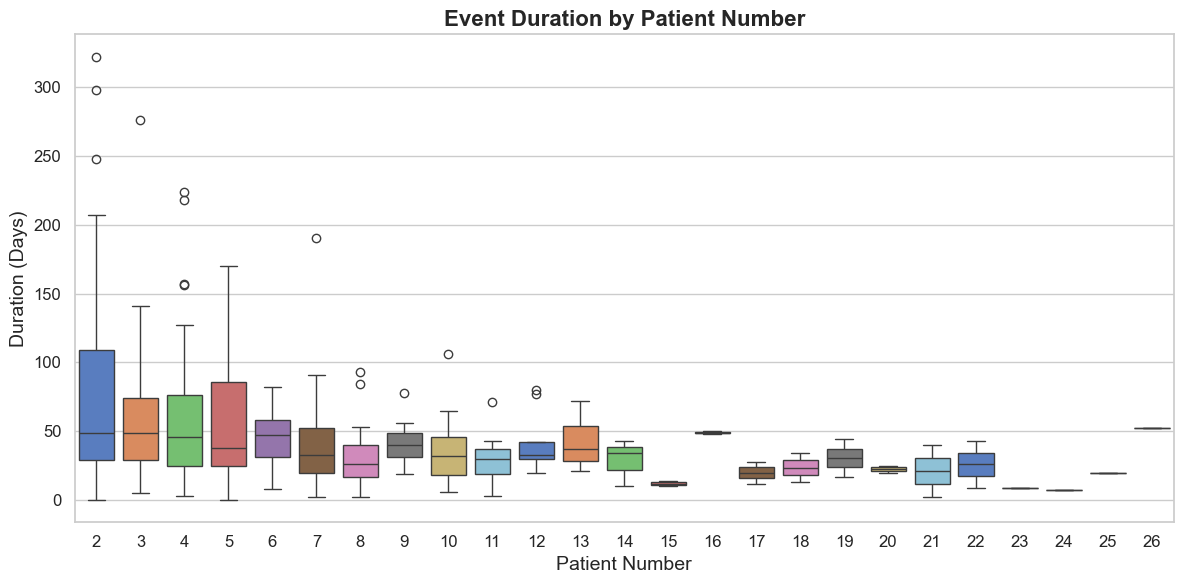

In [111]:
see_assumption(medB_clustered)